In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
import math

In [2]:

train_x_slide = torch.load('./Downloads/train_x_slide.pt')
train_y_slide = torch.load('./Downloads/train_y_slide.pt')
train_y_gan = torch.load('./Downloads/train_y_gan.pt')
test_x_slide = torch.load('./Downloads/test_x_slide.pt')
test_y_slide = torch.load('./Downloads/test_y_slide.pt')
test_y_gan = torch.load('./Downloads/test_y_gan.pt')
validation_x_slide = torch.load('./Downloads/validation_x_slide.pt')
validation_y_slide = torch.load('./Downloads/validation_y_slide.pt')
validation_y_gan = torch.load('./Downloads/validation_y_gan.pt')


print(f'validation_x_slide: {validation_x_slide.shape}')
print(f'validation_y_slide: {validation_y_slide.shape}')
print(f'validation_y_gan: {validation_y_gan.shape}')
print(f'train_x_slide: {train_x_slide.shape}')
print(f'train_y_slide: {train_y_slide.shape}')
print(f'train_y_gan: {train_y_gan.shape}')
print(f'test_x_slide: {test_x_slide.shape}')
print(f'test_y_slide: {test_y_slide.shape}')
print(f'test_y_gan: {test_y_gan.shape}')

validation_x_slide: torch.Size([397, 3, 35])
validation_y_slide: torch.Size([397, 1])
validation_y_gan: torch.Size([397, 4, 1])
train_x_slide: torch.Size([1862, 3, 35])
train_y_slide: torch.Size([1862, 1])
train_y_gan: torch.Size([1862, 4, 1])
test_x_slide: torch.Size([397, 3, 35])
test_y_slide: torch.Size([397, 1])
test_y_gan: torch.Size([397, 4, 1])


In [3]:
class Generator(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.lstm_1 = nn.LSTM(input_size, 1024, batch_first=True)
        self.lstm_2 = nn.LSTM(1024, 512, batch_first=True)
        self.lstm_3 = nn.LSTM(512, 256, batch_first=True)
        self.linear_1 = nn.Linear(256, 128)
        self.linear_2 = nn.Linear(128, 64)
        self.linear_3 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        use_cuda = 1
        device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")
        h0 = torch.zeros(1, x.size(0), 1024).to(device)
        c0 = torch.zeros(1, x.size(0), 1024).to(device)
        out_1, _ = self.lstm_1(x, (h0, c0))
        out_1 = self.dropout(out_1)
        h1 = torch.zeros(1, x.size(0), 512).to(device)
        c1 = torch.zeros(1, x.size(0), 512).to(device)
        out_2, _ = self.lstm_2(out_1, (h1, c1))
        out_2 = self.dropout(out_2)
        h2 = torch.zeros(1, x.size(0), 256).to(device)
        c2 = torch.zeros(1, x.size(0), 256).to(device)
        out_3, _ = self.lstm_3(out_2, (h2, c2))
        out_3 = self.dropout(out_3)
        out_4 = self.linear_1(out_3[:, -1, :])
        out_5 = self.linear_2(out_4)
        out = self.linear_3(out_5)
        return out

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(4, 32, kernel_size = 5, stride = 1, padding = 'same')
        self.conv2 = nn.Conv1d(32, 64, kernel_size = 5, stride = 1, padding = 'same')
        self.conv3 = nn.Conv1d(64, 128, kernel_size = 5, stride = 1, padding = 'same')
        self.linear1 = nn.Linear(128, 220)
        self.linear2 = nn.Linear(220, 220)
        self.linear3 = nn.Linear(220, 1)
        self.leaky = nn.LeakyReLU(0.01)
        self.relu = nn.ReLU()

    def forward(self, x):
        conv1 = self.conv1(x)
        conv1 = self.leaky(conv1)
        conv2 = self.conv2(conv1)
        conv2 = self.leaky(conv2)
        conv3 = self.conv3(conv2)
        conv3 = self.leaky(conv3)
        flatten_x =  conv3.reshape(conv3.shape[0], conv3.shape[1])
        out_1 = self.linear1(flatten_x)
        out_1 = self.leaky(out_1)
        out_2 = self.linear2(out_1)
        out_2 = self.relu(out_2)
        out = self.linear3(out_2)
        return out

##Training

In [4]:


class WGAN_GP(nn.Module):
    def __init__(self, generator, discriminator, device, learning_rate, lambda_gp):
        super(WGAN_GP, self).__init__()
        self.generator = generator.to(device)
        self.discriminator = discriminator.to(device)
        self.device = device
        self.lambda_gp = lambda_gp
        self.optimizerG = torch.optim.Adam(self.generator.parameters(), lr=learning_rate, betas=(0.0, 0.9), weight_decay=1e-3)
        self.optimizerD = torch.optim.Adam(self.discriminator.parameters(), lr=learning_rate, betas=(0.0, 0.9), weight_decay=1e-3)

    def compute_gradient_penalty(self, real_samples, fake_samples):
        alpha = torch.rand((real_samples.size(0), 1, 1), device=self.device)
        interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
        d_interpolates = self.discriminator(interpolates)
        fake = torch.ones(d_interpolates.size(), requires_grad=False, device=self.device)

        gradients = torch.autograd.grad(
            outputs=d_interpolates,
            inputs=interpolates,
            grad_outputs=fake,
            create_graph=True,
            retain_graph=True,
            only_inputs=True,
        )[0]

        gradients = gradients.view(gradients.size(0), -1)
        gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
        return gradient_penalty

    def train(self, dataloader, num_epochs, critic_iterations):
        histG = np.zeros(num_epochs)
        histD = np.zeros(num_epochs)
        count = 0

        for epoch in range(num_epochs):
            loss_G = []
            loss_D = []
            for x, y in dataloader:
                x, y = x.to(self.device), y.to(self.device)

                fake_data = self.generator(x)
                fake_data = torch.cat([y[:, :3, :], fake_data.reshape(-1, 1, 1)], axis=1)

                critic_real = self.discriminator(y)
                critic_fake = self.discriminator(fake_data)
                gradient_penalty = self.compute_gradient_penalty(y.data, fake_data.data)
                lossD = -(torch.mean(critic_real) - torch.mean(critic_fake)) + self.lambda_gp * gradient_penalty

                self.optimizerD.zero_grad()
                lossD.backward(retain_graph=True)
                self.optimizerD.step()

                if count % critic_iterations == 0:
                    output_fake = self.discriminator(fake_data)
                    lossG = -torch.mean(output_fake)
                    self.optimizerG.zero_grad()
                    lossG.backward()
                    self.optimizerG.step()
                    loss_G.append(lossG.item())

                loss_D.append(lossD.item())
                count += 1

            histG[epoch] = np.mean(loss_G) if loss_G else 0
            histD[epoch] = np.mean(loss_D)
            print(f'[{epoch+1}/{num_epochs}] LossD: {np.mean(loss_D)} LossG: {np.mean(loss_G)}')

        return histG, histD


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assuming Generator and Discriminator classes are defined with the appropriate input sizes
modelG = Generator(input_size=35)
modelD = Discriminator()
learning_rate = 0.00016
lambda_gp = 3
batch_size = 128
num_epochs =100
critic_iterations=5

wgan_gp = WGAN_GP(modelG, modelD, device, learning_rate, lambda_gp)

trainDataloader = DataLoader(TensorDataset(train_x_slide, train_y_gan), batch_size, shuffle=True)
histG, histD = wgan_gp.train(trainDataloader, num_epochs,critic_iterations)


[1/100] LossD: 2.980685997009277 LossG: 0.005698930937796831
[2/100] LossD: 2.895231088002523 LossG: 0.0011005801303933065
[3/100] LossD: 2.664579153060913 LossG: -0.007745105152328809
[4/100] LossD: 2.226999012629191 LossG: -0.023502643530567486
[5/100] LossD: 1.629538631439209 LossG: -0.050859466195106506
[6/100] LossD: 1.197489579518636 LossG: -0.13566304991642633
[7/100] LossD: 1.0513779163360595 LossG: -0.2536747306585312
[8/100] LossD: 0.8339663147926331 LossG: -0.3754593034585317
[9/100] LossD: 0.5305472473303477 LossG: -0.5149454474449158
[10/100] LossD: 0.42646292050679524 LossG: -0.7061827182769775
[11/100] LossD: 0.515429268280665 LossG: -0.938416322072347
[12/100] LossD: 0.6641510923703512 LossG: -1.207404375076294
[13/100] LossD: 0.9442136804262797 LossG: -1.5595708688100178
[14/100] LossD: 1.3128976345062255 LossG: -1.9296382665634155
[15/100] LossD: 1.4902251958847046 LossG: -2.128002087275187
[16/100] LossD: 1.1717571059862772 LossG: -2.0278812249501548
[17/100] LossD: 

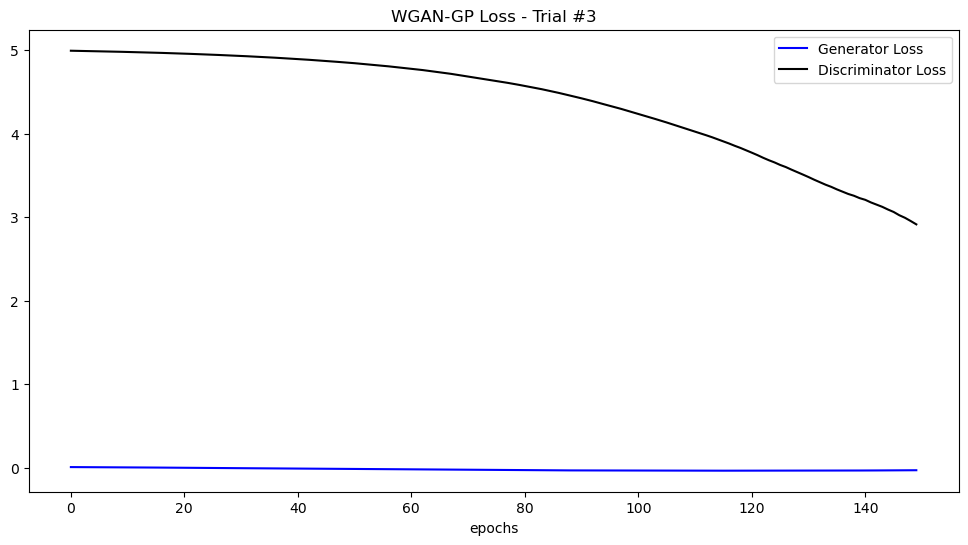

In [ ]:
num_trials =3
plt.figure(figsize = (12, 6))
plt.plot(histG, color = 'blue', label = 'Generator Loss')
plt.plot(histD, color = 'black', label = 'Discriminator Loss')
plt.title(f'WGAN-GP Loss - Trial #{num_trials}')
plt.xlabel('epochs')
plt.legend(loc = 'upper right')


In [ ]:
modelG.eval()
pred_y_train = modelG(train_x_slide.to(device))
pred_y_test = modelG(test_x_slide.to(device))

y_train = train_y_slide
y_test = test_y_slide

In [ ]:
import pickle

# Load the saved scaler
y_scaler = pickle.load(open('./Downloads/target_scaler.pkl', 'rb'))

# Use the loaded scaler to inverse transform the data
rescaled_y_train = y_scaler.inverse_transform(y_train)
rescaled_y_test = y_scaler.inverse_transform(y_test)


rescaled_pred_y_train = y_scaler.inverse_transform(pred_y_train.detach().numpy())
rescaled_pred_y_test = y_scaler.inverse_transform(pred_y_test.detach().numpy())

Training dataset RMSE:1.8754636246213987


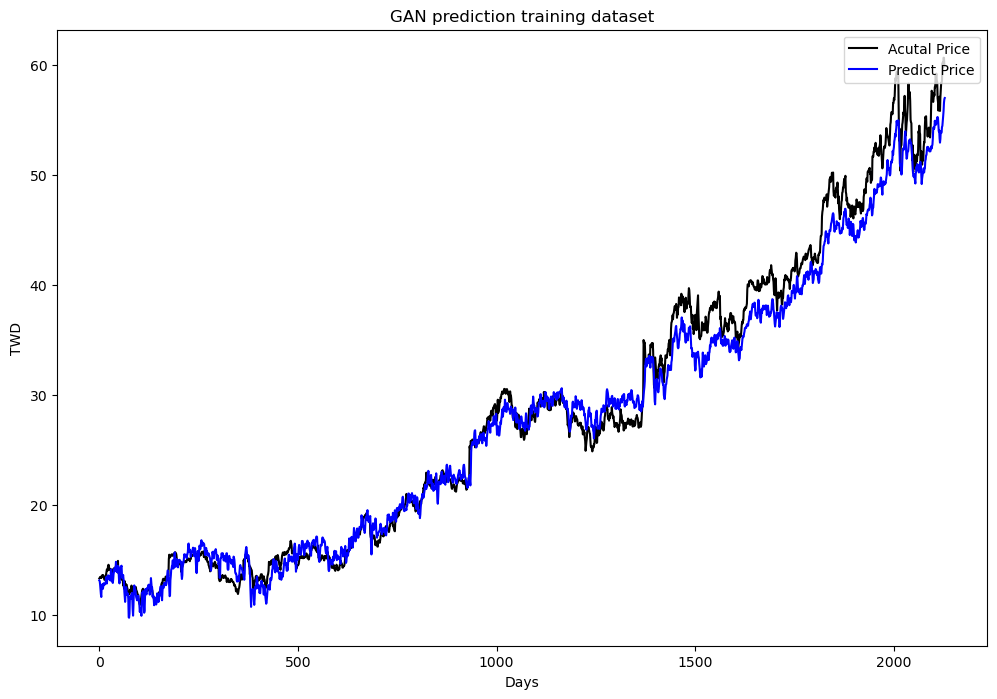

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(rescaled_y_train, color = 'black', label = 'Acutal Price')
plt.plot(rescaled_pred_y_train, color = 'blue', label = 'Predict Price')

plt.title('GAN prediction training dataset')
plt.ylabel('TWD')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(rescaled_y_train, rescaled_pred_y_train)
RMSE = math.sqrt(MSE)
print(f'Training dataset RMSE:{RMSE}')

Training dataset RMSE:3.942455971645756


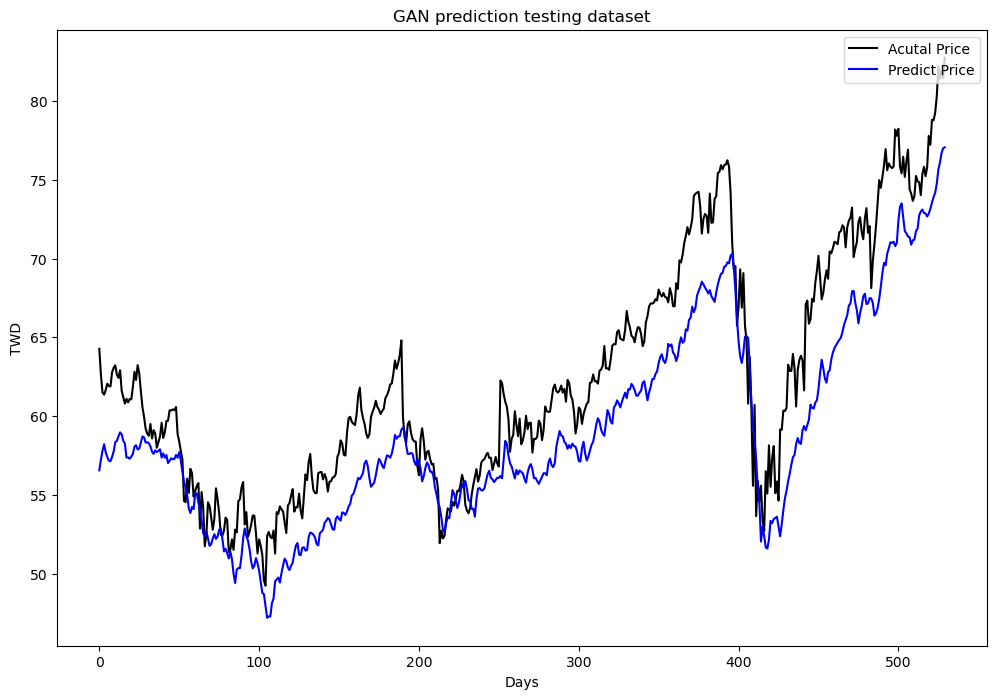

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(rescaled_y_test, color = 'black', label = 'Acutal Price')
plt.plot(rescaled_pred_y_test, color = 'blue', label = 'Predict Price')
plt.title('GAN prediction testing dataset')
plt.ylabel('TWD')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(rescaled_y_test, rescaled_pred_y_test)
RMSE = math.sqrt(MSE)
print(f'Training dataset RMSE:{RMSE}')

##Hyperparameter Tuning

In [ ]:
batch_size_options = [64, 128]
learning_rate_options = [0.001, 0.0001, 0.00001]
num_epochs_options = [150, 200, 250, 300]
lambda_gp_options = [2, 3, 4]
critic_iterations_options = [3, 4]



num_trials = 60  # Number of trials in the random search
best_rmse = float('inf')
best_params = {}

for trial in range(num_trials):
    batch_size = int(np.random.choice(batch_size_options))
    learning_rate = float(np.random.choice(learning_rate_options))
    num_epochs = int(np.random.choice(num_epochs_options))
    lambda_gp = int(np.random.choice(lambda_gp_options))
    critic_iterations = int(np.random.choice(critic_iterations_options))
    input_size = 35
    print(f'num trial: {trial}, batch_size: {batch_size}, learning_rate: {learning_rate}, num_epochs: {num_epochs}, critic_iterations: {critic_iterations}, lambda_gp: {lambda_gp}')

    modelG = Generator(input_size=35)
    modelD = Discriminator()


    wgan_gp = WGAN_GP(modelG, modelD, device, learning_rate, lambda_gp)

    trainDataloader = DataLoader(TensorDataset(train_x_slide, train_y_gan), batch_size, shuffle=True)
    histG, histD = wgan_gp.train(trainDataloader, num_epochs,critic_iterations)

    plt.figure(figsize = (12, 6))
    plt.plot(histG, color = 'blue', label = 'Generator Loss')
    plt.plot(histD, color = 'black', label = 'Discriminator Loss')
    plt.title(f'WGAN-GP Loss - Trial #{trial}')
    plt.xlabel('epochs')
    plt.legend(loc = 'upper right')

    modelG.eval()


    pred_y_validation = modelG(validation_x_slide.to(device))

    rescaled_y_validation = y_scaler.inverse_transform(validation_y_slide)

    rescaled_pred_y_validation = y_scaler.inverse_transform(pred_y_validation.detach().numpy())

    MSE_validation = mean_squared_error(rescaled_y_validation, rescaled_pred_y_validation)
    rmse = math.sqrt(MSE_validation)
    print(rmse)

    if rmse < best_rmse:
        best_rmse = rmse
        best_params = {'batch_size': batch_size, 'learning_rate': learning_rate, 'num_epochs': num_epochs , 'critic_iterations': critic_iterations, 'lambda_gp': lambda_gp}

print(f"Best Parameters: {best_params}")
print(f"Best RMSE: {best_rmse}")

Output hidden; open in https://colab.research.google.com to view.

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assuming Generator and Discriminator classes are defined with the appropriate input sizes
modelG = Generator(input_size=35)
modelD = Discriminator()
learning_rate = 0.0001
lambda_gp = 3
batch_size = 64
num_epochs =150
critic_iterations=3

wgan_gp = WGAN_GP(modelG, modelD, device, learning_rate, lambda_gp)

trainDataloader = DataLoader(TensorDataset(train_x_slide, train_y_gan), batch_size, shuffle=True)
histG, histD = wgan_gp.train(trainDataloader, num_epochs,critic_iterations)


[1/150] LossD: 2.9699059168497723 LossG: -0.0535586915910244
[2/150] LossD: 2.817611885070801 LossG: -0.0627089213579893
[3/150] LossD: 2.4463141679763796 LossG: -0.07593874409794807
[4/150] LossD: 2.077884801228841 LossG: -0.12316842302680016
[5/150] LossD: 1.9625141421953838 LossG: -0.23377929180860518
[6/150] LossD: 1.9905693332354228 LossG: -0.3740294098854065
[7/150] LossD: 2.0223532636960346 LossG: -0.5643283516168595
[8/150] LossD: 2.310887932777405 LossG: -0.9886815667152404
[9/150] LossD: 3.1279294808705647 LossG: -1.7868069291114808
[10/150] LossD: 3.6576022545496625 LossG: -1.7723140954971313
[11/150] LossD: 3.5631148258845013 LossG: -1.3047438621520997
[12/150] LossD: 3.265927306811015 LossG: -0.778655332326889
[13/150] LossD: 2.927920850118001 LossG: -0.3444081336259842
[14/150] LossD: 2.448780337969462 LossG: -0.03200770290568471
[15/150] LossD: 1.7933560808499653 LossG: 0.16426874846220016
[16/150] LossD: 1.0500233193238577 LossG: 0.23334639966487886
[17/150] LossD: 0.66

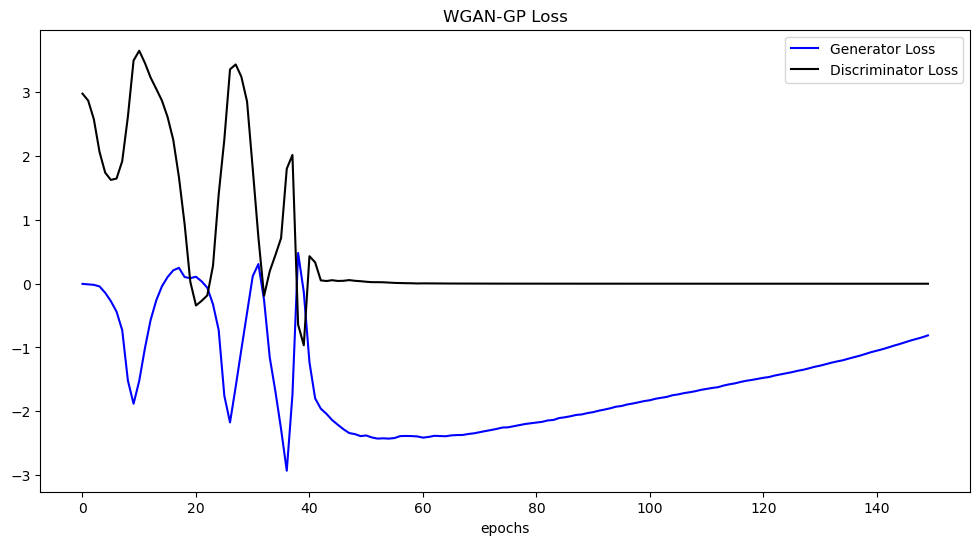

In [ ]:
plt.figure(figsize = (12, 6))
plt.plot(histG, color = 'blue', label = 'Generator Loss')
plt.plot(histD, color = 'black', label = 'Discriminator Loss')
plt.title('WGAN-GP Loss')
plt.xlabel('epochs')
plt.legend(loc = 'upper right')

In [7]:
modelG.eval()
pred_y_train = modelG(train_x_slide.to(device))
pred_y_test = modelG(test_x_slide.to(device))

y_train = train_y_slide
y_test = test_y_slide

In [8]:
import pickle

# Load the saved scaler
y_scaler = pickle.load(open('./Downloads/target_scaler.pkl', 'rb'))

# Use the loaded scaler to inverse transform the data
rescaled_y_train = y_scaler.inverse_transform(y_train)
rescaled_y_test = y_scaler.inverse_transform(y_test)


rescaled_pred_y_train = y_scaler.inverse_transform(pred_y_train.detach().numpy())
rescaled_pred_y_test = y_scaler.inverse_transform(pred_y_test.detach().numpy())

/opt/anaconda3/lib/python3.10/site-packages/sklearn/base.py:299: UserWarning: Trying to unpickle estimator MinMaxScaler from version 1.2.2 when using version 1.2.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Training dataset RMSE:1.6250021464777493
Train dataset MAPE:0.06678810625854781
Train dataset MAE:1.3462305011829745


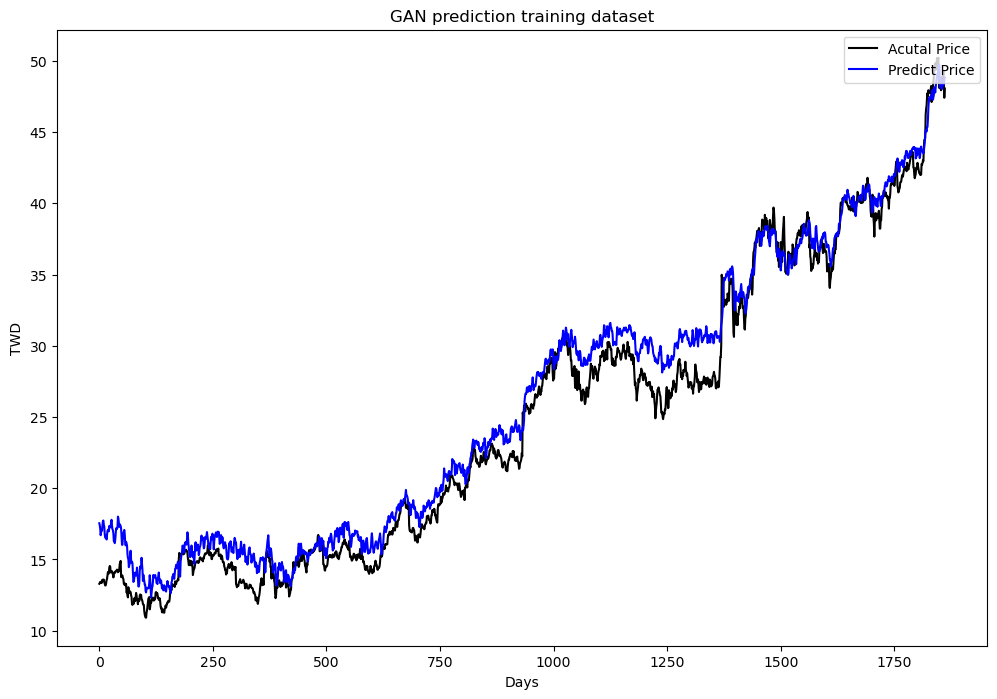

In [9]:
plt.figure(figsize=(12, 8))
plt.plot(rescaled_y_train, color = 'black', label = 'Acutal Price')
plt.plot(rescaled_pred_y_train, color = 'blue', label = 'Predict Price')

plt.title('GAN prediction training dataset')
plt.ylabel('TWD')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(rescaled_y_train, rescaled_pred_y_train)
RMSE = math.sqrt(MSE)
MAPE = mean_absolute_percentage_error(rescaled_y_train, rescaled_pred_y_train)
MAE = mean_absolute_error(rescaled_y_train, rescaled_pred_y_train)
print(f'Training dataset RMSE:{RMSE}')
print(f'Train dataset MAPE:{MAPE}')
print(f'Train dataset MAE:{MAE}')

Training dataset RMSE:2.4118196951255335
Train dataset MAPE:0.029510234734784844
Train dataset MAE:1.8041137188526795


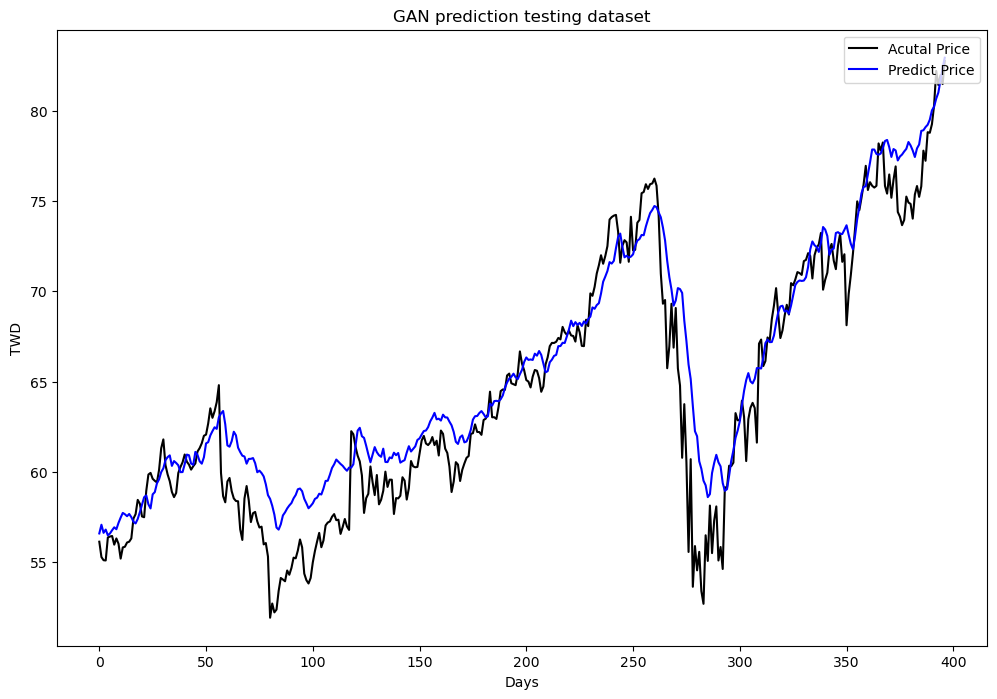

In [10]:
plt.figure(figsize=(12, 8))
plt.plot(rescaled_y_test, color = 'black', label = 'Acutal Price')
plt.plot(rescaled_pred_y_test, color = 'blue', label = 'Predict Price')
plt.title('GAN prediction testing dataset')
plt.ylabel('TWD')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(rescaled_y_test, rescaled_pred_y_test)
RMSE = math.sqrt(MSE)
MAPE = mean_absolute_percentage_error(rescaled_y_test, rescaled_pred_y_test)
MAE = mean_absolute_error(rescaled_y_test, rescaled_pred_y_test)
print(f'Training dataset RMSE:{RMSE}')
print(f'Train dataset MAPE:{MAPE}')
print(f'Train dataset MAE:{MAE}')

##Subsampling

In [11]:
y_test = test_y_slide

subsample_rmses = []


# Iterate over the test set in windows of 50 days
for start in range(0, len(test_x_slide), 50):
    end = start + 50
    # If the last window has less than 50 days, we take whatever is remaining
    if end > len(test_x_slide):
        end = len(test_x_slide)

    # Slice the test set to get a subsample
    subsample_x = test_x_slide[start:end]
    subsample_y = y_test[start:end]

    # Make predictions on the subsample
    pred_y_subsample = modelG(subsample_x.to(device))

    # Use the loaded scaler to inverse transform the data

    rescaled_y_test = y_scaler.inverse_transform(subsample_y)

    rescaled_pred_y_test = y_scaler.inverse_transform(pred_y_subsample.detach().numpy())

    MSE = mean_squared_error(rescaled_y_test, rescaled_pred_y_test)
    RMSE = math.sqrt(MSE)
    subsample_rmses.append(RMSE)


print(f'Subsample RMSE: {subsample_rmses}')

Subsample RMSE: [1.1110527402647987, 3.422160376357663, 2.384753510741932, 1.227177789849151, 1.241112299162214, 4.234526583587336, 1.5104949219509776, 2.137353837173063]


In [13]:
df = pd.DataFrame(subsample_rmses, columns=['RMSE'])


df.to_csv('./Downloads/WGANsubsample_rmses.csv', index=False)

